In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

prng = np.random.RandomState(20250317)

%precision 3
pd.set_option('display.precision', 3)
np.set_printoptions(suppress=True, precision=3)

# Predict the demand for bike share using tree-based methods

## Recreate the data sets

In [8]:
# sample data
bike_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2025/data/bike_sharing_demand/bike_sample.csv")
features = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]

train_indices = pd.to_datetime(bike_data['datetime']).dt.day <= 15
X_train = features[train_indices]
X_test = features[~train_indices]
y_train = label[train_indices]
y_test = label[~train_indices]

# feature engineered data
def extractDtFeatures(df_with_datetime):
    df_with_datetime['datetime'] = pd.to_datetime(df_with_datetime['datetime'], utc=True)
    df_with_datetime['year'] = df_with_datetime['datetime'].dt.year
    df_with_datetime['month'] = df_with_datetime['datetime'].dt.month
    df_with_datetime['hour'] = df_with_datetime['datetime'].dt.hour
    df_with_datetime['dayofweek'] = df_with_datetime['datetime'].dt.dayofweek

extractDtFeatures(bike_data)

feature_matrix = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
X_train_fe = feature_matrix[train_indices]
X_test_fe = feature_matrix[~train_indices]


# full data
bike_full = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/train.csv")
extractDtFeatures(bike_full)

full_data_train = bike_full[bike_full.datetime.dt.day <= 15]

X_full = full_data_train.drop(columns=["count", "registered", "casual", "datetime"])
y_full = full_data_train['count']

In [9]:
# Summary table for the various data sets
data_objects = ['X_train', 'X_train_fe', 'y_train', 'X_full', 'y_full', 'X_test', 'X_test_fe', 'y_test']
data_summary = {
    name: {
        'number_of_rows': locals()[name].shape[0], 
        'number_of_columns': locals()[name].shape[1] if len(locals()[name].shape) > 1 else 1
    } 
    for name in data_objects
}

pd.DataFrame(data_summary).T

,number_of_rows,number_of_columns
X_train,1735,8
X_train_fe,1735,12
y_train,1735,1
X_full,8600,12
y_full,8600,1
X_test,442,8
X_test_fe,442,12
y_test,442,1


### Evaluation

In [10]:
def calculateRMSLE(prediction, y_obs):
    return np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) -
                np.log(y_obs + 1)
            )**2
        )
    )

class ResultCollector:
    def __init__(self):
        self.results = {}
        
    def add_model(self, name, train_error, test_error):
        """Add or update a model's results."""
        self.results[name] = {
            'Train RMSLE': train_error,
            'Test RMSLE': test_error
        }
        return self.get_table()
    
    def get_table(self, style=True):
        """Get the results table with optional styling."""
        df = pd.DataFrame(self.results).T
        if style:
            return df.style.format("{:.3f}").background_gradient(cmap='RdYlGn_r', axis=None)
        return df

## Benchmark: Linear model


We aim to build a pipeline that can process all datasets within a single loop. Since the exact dummy features depend on whether we are working with the raw or feature-engineered data, we need to define the encoding step carefully.

To achieve this, we introduce a new method, `make_column_selector`, which selects columns based on a regex pattern or data types. We will apply one-hot encoding to all columns except those listed in `numeric_features`. The complex regex below simply ensures that columns named `temp`, `atemp`, `humidity`, or `windspeed` are excluded from encoding.

If you’re not familiar with regular expressions, don’t worry—they won’t be required for any assignments. However, I highly recommend learning the basics, as they can be incredibly useful.

In [11]:
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed']

steps = [
    ("create_features", ColumnTransformer([
        ("keep_numeric_features", "passthrough", numeric_features),
        ("create_dummies", OneHotEncoder(sparse_output=False, drop='first'), make_column_selector(pattern='^(?!(' + '|'.join(numeric_features) + ')$).*'))
    ])),
    ("ols", LinearRegression())
]

pipe_linear = Pipeline(steps)

In [12]:
models = ["Linear", "Feature engineered linear", "Feature engineered linear large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

results = ResultCollector()

for model, (train_features, train_labels, test_features) in zip(models, datasets):

    pipe_linear.fit(train_features, train_labels)

    train_error = calculateRMSLE(pipe_linear.predict(train_features), train_labels)
    test_error = calculateRMSLE(pipe_linear.predict(test_features), y_test)

    results.add_model(model, train_error, test_error)

results.get_table()

/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1597: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]
/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1597: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]
/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1597: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  cols = cols[cols.str.contains(self.pattern, regex=True)]


,Train RMSLE,Test RMSLE
Linear,1.383,1.431
Feature engineered linear,1.100,1.201
Feature engineered linear large n,1.114,1.177


## Model #5: Tree

**TODO**: Estimate a tree model on all the datasets and evaluate their perfomance. Add the results to the `results` object by using its `add_model()` method.

In [16]:
# TBA
pipe_tree = Pipeline([
    ('tree', DecisionTreeRegressor(max_depth=3, random_state=prng))
])
models = ["Tree", "Tree feature eng", "Tree feature eng large n"]

for model, (train_features, train_labels, test_features) in zip(models, datasets):

    pipe_tree.fit(train_features, train_labels)

    train_error = calculateRMSLE(pipe_tree.predict(train_features), train_labels)
    test_error = calculateRMSLE(pipe_tree.predict(test_features), y_test)

    results.add_model(model, train_error, test_error)

results.get_table()


,Train RMSLE,Test RMSLE
Linear,1.383,1.431
Feature engineered linear,1.100,1.201
Feature engineered linear large n,1.114,1.177
Tree,1.336,1.413
Tree feature eng,0.802,0.815
Tree feature eng large n,0.807,0.774


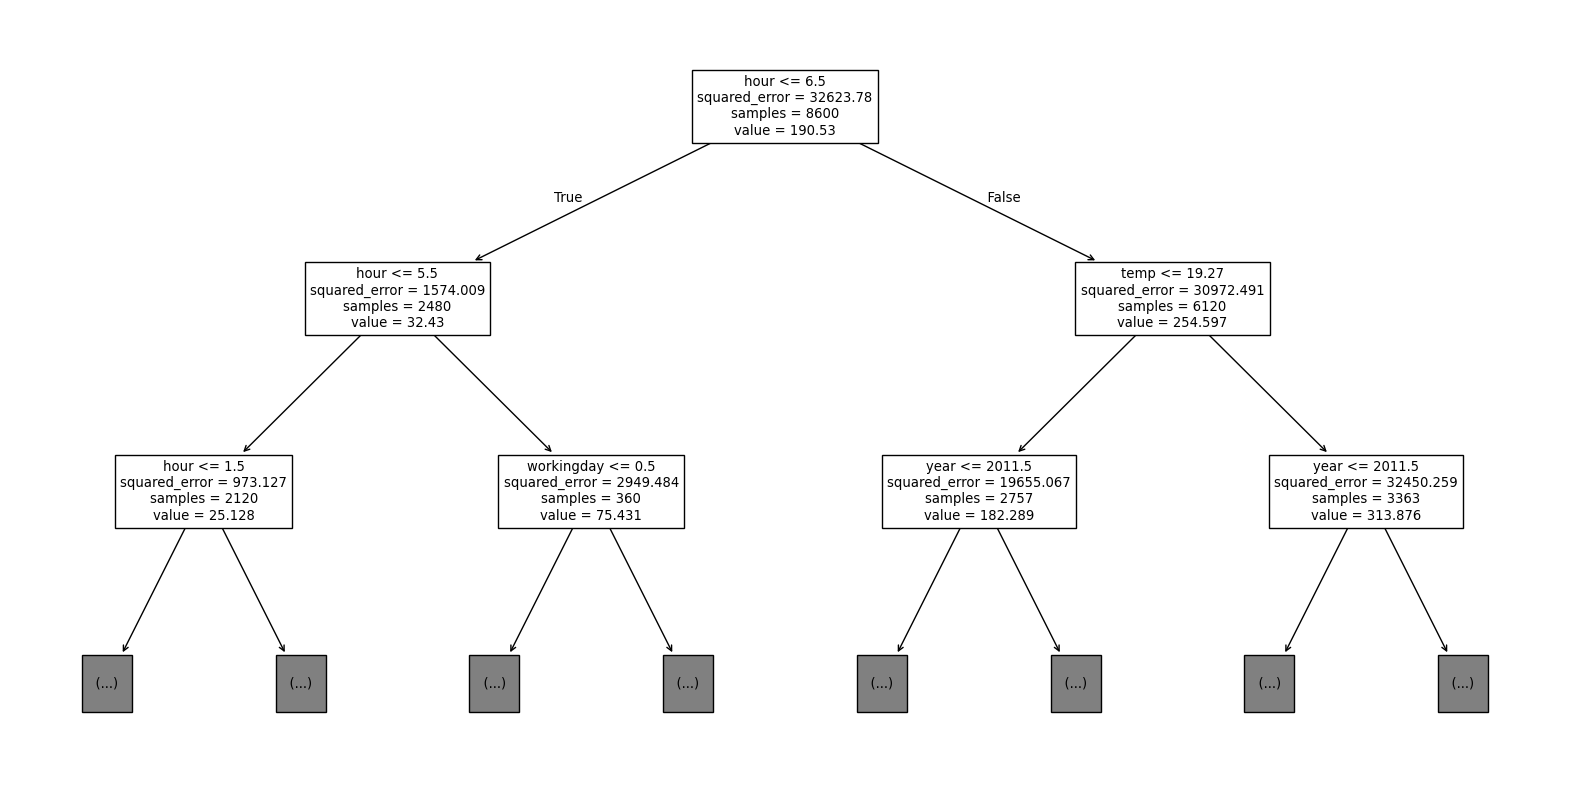

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(pipe_tree['tree'], feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [17]:
pipe_deep_tree = Pipeline([('tree', DecisionTreeRegressor(max_depth=31, random_state=prng))])

models = ["Deep tree", "Feature engineered deep tree", "Feature engineered deep tree large n"]

for model, (train_features, train_labels, test_features) in zip(models, datasets):

    pipe_deep_tree.fit(train_features, train_labels)

    train_error = calculateRMSLE(pipe_deep_tree.predict(train_features), train_labels)
    test_error = calculateRMSLE(pipe_deep_tree.predict(test_features), y_test)

    results.add_model(model, train_error, test_error)

results.get_table()

,Train RMSLE,Test RMSLE
Linear,1.383,1.431
Feature engineered linear,1.100,1.201
Feature engineered linear large n,1.114,1.177
Tree,1.336,1.413
Tree feature eng,0.802,0.815
Tree feature eng large n,0.807,0.774
Deep tree,0.226,1.811
Feature engineered deep tree,0.000,0.633
Feature engineered deep tree large n,0.010,0.460


**Lessons:**

- A simple tree can capture complex (non-linear) relationships (we achieved much better performance than with the cumbersome LASSO without any tweaks). This does not mean that LASSO is useless, only that the tree seems to be a much better fit for this problem.
- More data did not really help the shallow tree (`max_depth=5`) because it was not complex enough -- it did help the deep tree but also led to massive overfitting on the sample dataset (compare the test set performance of the two tree models on the sample dataset).
- Actually, the deep tree overfits on all datasets as test error is always larger than the train error; however, it is less of a problem until the test error is still better than with the less complex model. It would be a good exercise to choose the `max_depth` parameter by cross-validation.

## Model #6: Random forest

### Default settings

In [24]:
# random forest
pipe_rf = Pipeline([('random_forest', RandomForestRegressor())])

models = ["RF", "Feature engineered RF", "Feature engineered RF large n"]

for model, (train_features, train_labels, test_features) in zip(models, datasets):

    pipe_rf.fit(train_features, train_labels)

    train_error = calculateRMSLE(pipe_rf.predict(train_features), train_labels)
    test_error = calculateRMSLE(pipe_rf.predict(test_features), y_test)

    results.add_model(model, train_error, test_error)

results.get_table()

,Train RMSLE,Test RMSLE
Linear,1.383,1.431
Feature engineered linear,1.100,1.201
Feature engineered linear large n,1.114,1.177
Tree,1.336,1.413
Tree feature eng,0.802,0.815
Tree feature eng large n,0.807,0.774
Deep tree,0.226,1.811
Feature engineered deep tree,0.000,0.633
Feature engineered deep tree large n,0.010,0.460
RF,0.813,1.372


In [21]:
pipe_rf['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.000,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 1.000,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.000,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.000,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

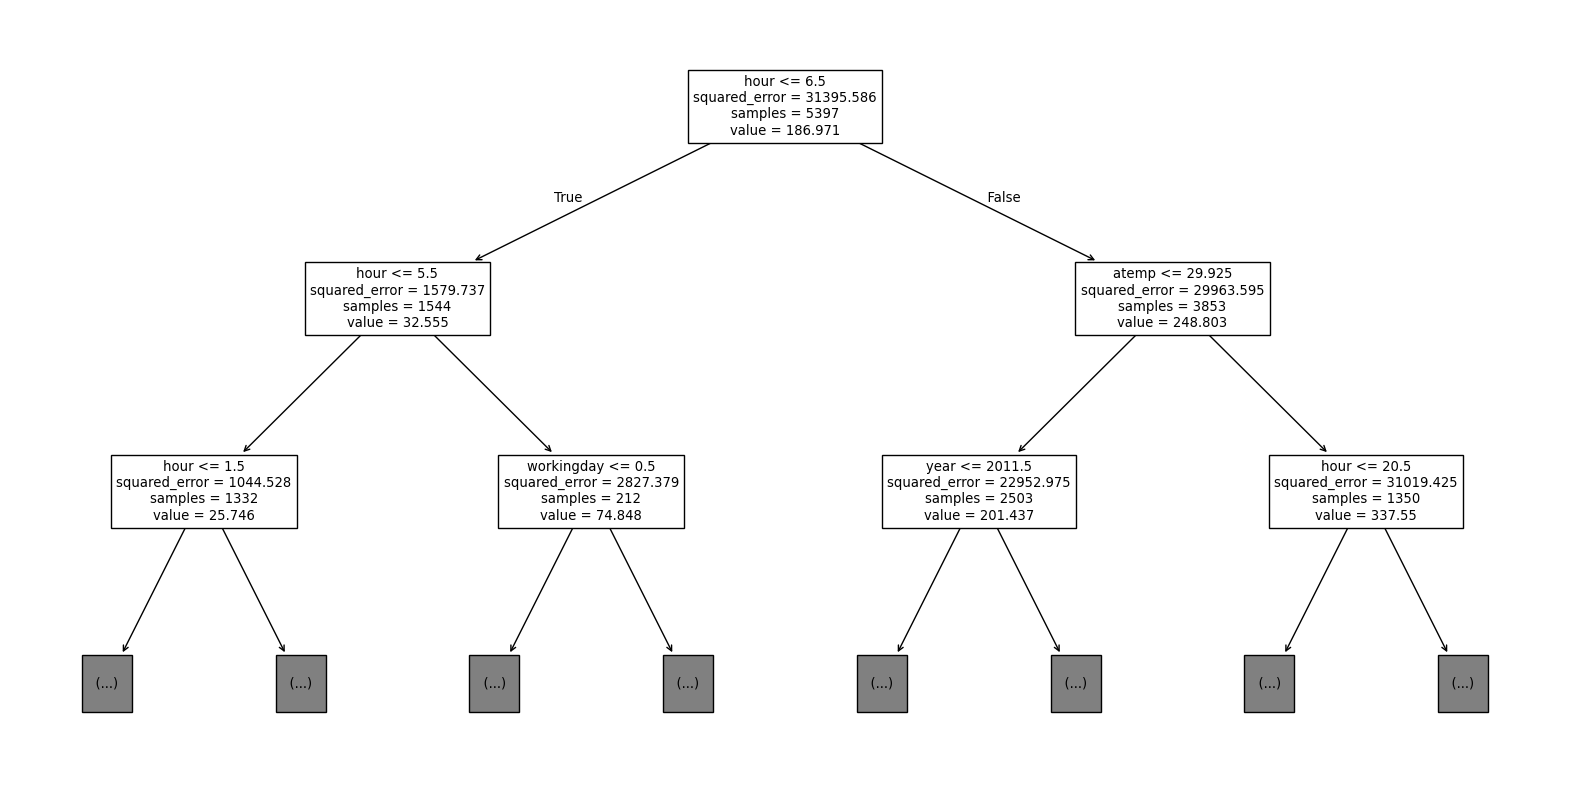

In [22]:
# Look at single trees
chosen_tree = pipe_rf['random_forest'].estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(chosen_tree, feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

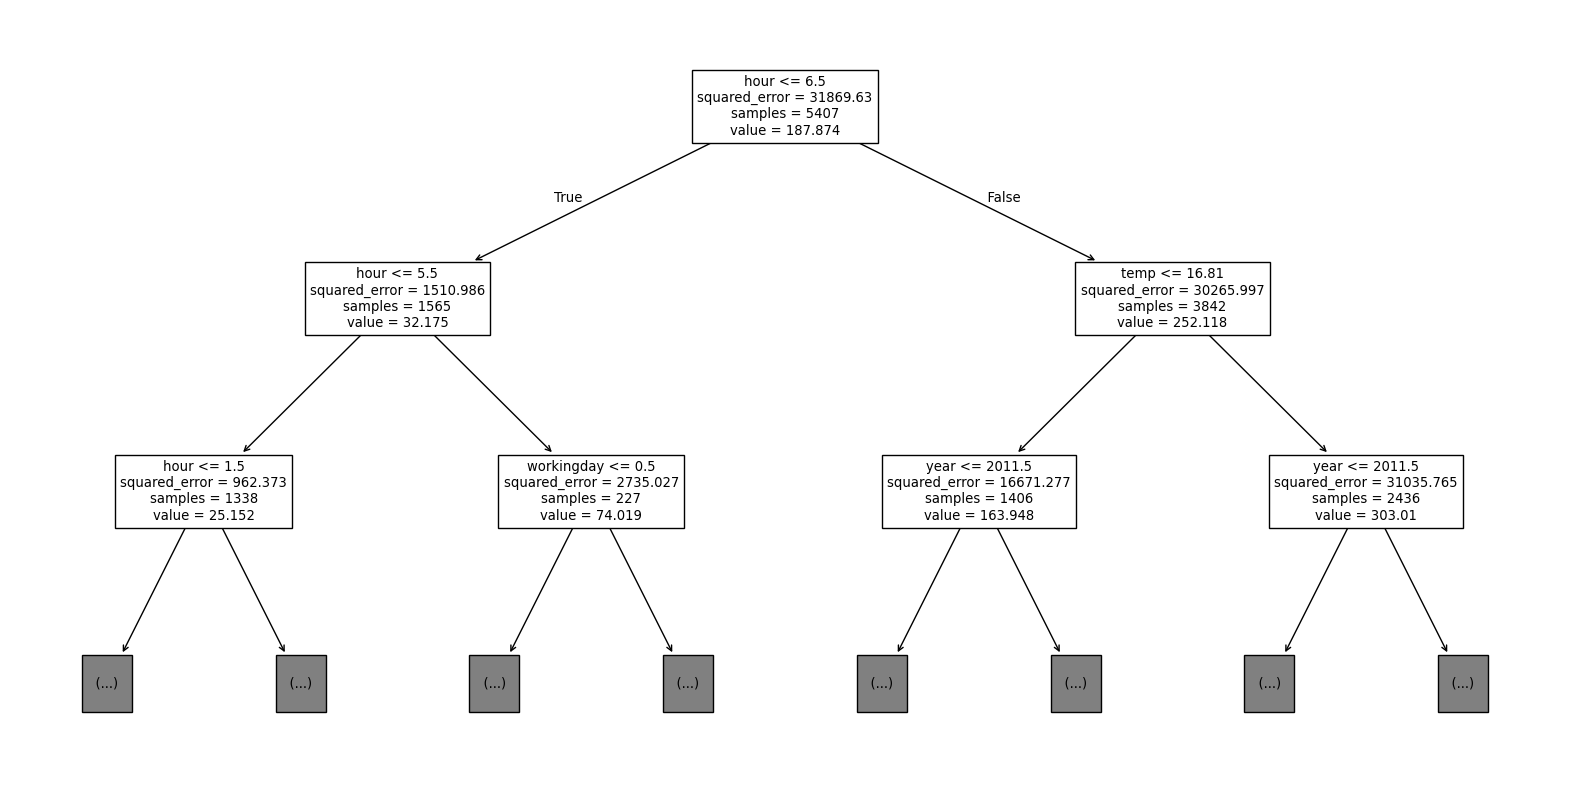

In [23]:
chosen_tree = pipe_rf['random_forest'].estimators_[1]
plt.figure(figsize=(20, 10))
plot_tree(chosen_tree, feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [ ]:
(chosen_tree.tree_.max_depth, chosen_tree.tree_.node_count)

**Lessons:**

- Interestingly, the default `RandomForestRegressor` does not randomly choose from the features at each split (as `max_features = n_features`), it is equivalent to bagged trees. Also, there is no restricition on the size of the tree (`max_depth = None, max_leaf_nodes: None, min_samples_leaf = 1, min_samples_split: 2`).
- Each tree in a random forest tends to memorize the training data. However, since each tree is trained on a bootstrapped sample—a randomly drawn subset with replacement—the aggregated prediction is less prone to overfitting. This demonstrates how bootstrapping inherently contributes to generalization.

### Hyper-parameter tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [0.05, 0.5, 0.7, 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
random_grid

In [ ]:
# NOTE! This cell requires sklearn 1.4+
# WARNING! This cell might take several minutes to run. Decrease `n_iter` to make it quicker (and less thorough)

# hyper-parameter tuning - fit the models on the full sample
rf = RandomForestRegressor(random_state=prng)

# Random search of parameters, using 5 fold cross validation,
# search across n_iter different combinations, and use all available cores, evaluate by RMSLE
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=5, scoring='neg_root_mean_squared_log_error', verbose=2, random_state=prng, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_full, y_full)

In [ ]:
rf_random.best_params_

In [ ]:
pd.DataFrame(rf_random.cv_results_)

In [ ]:
train_error = calculateRMSLE(rf_random.best_estimator_.predict(X_full), y_full)
test_error = calculateRMSLE(rf_random.best_estimator_.predict(X_test_fe), y_test)
results.add_model("CV RF large n", train_error, test_error)

## Model #7: XGBoost

### Technical detour: category type

In [26]:
X_full.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
year            int32
month           int32
hour            int32
dayofweek       int32
dtype: object

In [27]:
dummy_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour', 'dayofweek']
X_full[dummy_features] = X_full[dummy_features].astype('category')
X_full.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
month         category
hour          category
dayofweek     category
dtype: object

Why we did not deal with this so far? Because sklearn's implementation of trees [does not handle them differently](https://scikit-learn.org/stable/modules/tree.html#:~:text=and%20categorical%20data.-,However%2C%20the%20scikit%2Dlearn%20implementation%20does%20not%20support%20categorical%20variables%20for%20now.,-Other%20techniques%20are).

In [ ]:
# Illustration
pipe_tree.fit(X_full, y_full)

train_error = calculateRMSLE(pipe_tree.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_tree.predict(X_test_fe), y_test)

results.add_model("Tree large n categories", train_error, test_error)


In [ ]:
plt.figure(figsize=(20,10))
plot_tree(pipe_tree["tree"], feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [28]:
# Boosted tree: xgboost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(enable_categorical=True).fit(X_full, y_full)

In [ ]:
train_error = calculateRMSLE(xgb_model.predict(X_full), y_full)
test_error = calculateRMSLE(xgb_model.predict(X_test_fe), y_test)

["XGB", train_error, test_error]

In [29]:
xgb_model.get_booster().trees_to_dataframe().head(10)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,hour,NaN,0-2,0-1,0-1,1.004e+08,8600.0,"[0, 1, 2, 3, 4, 5, 6, 22, 23]"
1,0,1,0-1,hour,NaN,0-4,0-3,0-3,2.861e+07,5400.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
2,0,2,0-2,hour,NaN,0-6,0-5,0-5,3.918e+06,3200.0,"[0, 1, 2, 3, 4, 5]"
3,0,3,0-3,year,NaN,0-8,0-7,0-7,1.629e+07,1800.0,[0]
4,0,4,0-4,year,NaN,0-10,0-9,0-9,1.140e+07,3600.0,[0]
5,0,5,0-5,temp,18.86,0-11,0-12,0-12,9.626e+05,1080.0,None
6,0,6,0-6,hour,NaN,0-14,0-13,0-13,3.871e+05,2120.0,"[2, 3, 4, 5]"
7,0,7,0-7,workingday,NaN,0-16,0-15,0-15,9.370e+06,900.0,[0]
8,0,8,0-8,month,NaN,0-18,0-17,0-17,6.957e+06,900.0,"[0, 1, 2, 3]"
9,0,9,0-9,season,NaN,0-20,0-19,0-19,5.849e+06,1800.0,[0]


In [ ]:
# Hyperparameter tuning for xgboost model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(enable_categorical=True)

def safe_rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)  # clip predictions at 0
    return -np.sqrt(mean_squared_log_error(y_true, y_pred))

xgb_random = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_grid, 
    n_iter=100, cv=5, scoring=make_scorer(safe_rmsle), verbose=2, random_state=prng, n_jobs=-1
)

xgb_random.fit(X_full, y_full)

In [ ]:

best_xgb_model = xgb_random.best_estimator_

train_error = calculateRMSLE(best_xgb_model.predict(X_full), y_full)
test_error = calculateRMSLE(best_xgb_model.predict(X_test_fe), y_test)

["XGB Tuned", train_error, test_error]


**Lessons:**

- "Both xgboost and gbm follows the principle of gradient boosting. There are however, the difference in modeling details. Specifically, xgboost used a more regularized model formalization to control over-fitting, which gives it better performance." [Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- xgboost can handle categorical values, resulting in rules defined by sets instead of simple numerical cuts
- for this particular problem, Random Forest performed better than xgboost

## Submit to Kaggle

Kaggle provides a test set without any labels. Our task is to predict these labels and submit to Kaggle which will evaluate our model's performance based on its evaluation metric (RMSLE in this case).

In [31]:
bike_test = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2025/data/bike_sharing_demand/test.csv")
extractDtFeatures(bike_test)

# ensure we comply with the formatting requirement by Kaggle
to_submit = pd.DataFrame({
    'datetime': bike_test.datetime.dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count': pipe_rf.predict(bike_test.drop(columns=["datetime"]))
})

to_submit.to_csv("../data/bike_sharing_demand/submission_class.csv", index=False)
